# Filter pack analysis meta data creation
Saves filter pack alignment information for betatron beam analysis

In [1]:
import sys, os
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import interp1d

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter

from PIL import Image
from skimage.measure import label, regionprops
import pickle

import XANES2020_code.Betatron_analysis.xray_analysis as xray
from XANES2020_code.Betatron_analysis.beam_fitting import GP_beam_fitter
from XANES2020_code.Betatron_analysis.mask_tools import reorder_labels
from XANES2020_code.paths import CAL_DATA

def load_lundatron(file_path):
    return np.array(Image.open(file_path)).astype(float)

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as fid:
        return pickle.load(fid)

BASE_PATH =r'/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/'

def imagesc(I,ax = None,  x=None, y=None, **kwargs):
    """ display image with axes using pyplot
    recreates matlab imagesc functionality (roughly)
    argument I = 2D numpy array for plotting
    kwargs:
        ax = axes to plot on, if None will make a new one
        x = horizontal  axis - just uses first an last values to set extent
        y = vetical axis like x
        **kwargs anthing else which is passed to imshow except extent and aspec which are set
    """
    if ax is None:
        plt.figure()
        ax = plt.axes()
    if x is None:
        Nx = np.size(I, axis=1)
        x = np.arange(Nx)
    if y is None:
        Ny = np.size(I, axis=0)
        y = np.arange(Ny)
    ext = (x[0], x[-1], y[-1], y[0])
    return ax.imshow(I, extent=ext, aspect='auto', **kwargs)

## Load representative image and background image and camera info

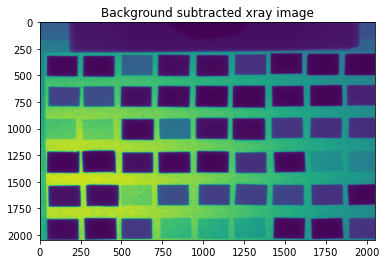

In [34]:

bkg_file = os.path.join(BASE_PATH,'Gematron/20200907/run01/Shot001.tif')

img_file = os.path.join(BASE_PATH,'Gematron/20200907/run04/Shot001.tif')

bkg_img = load_lundatron(bkg_file)
rep_img = load_lundatron(img_file)                      
img_sub = rep_img - bkg_img
img_sub = median_filter(img_sub,(3, 3));
imagesc(img_sub)
plt.title('Background subtracted xray image');


## Determine beam region
### Approximate transmission measurement

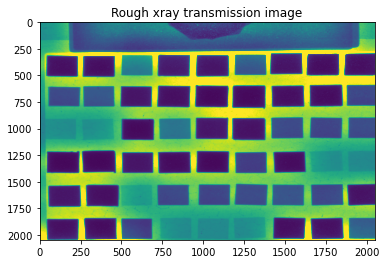

In [35]:
img_sub_smooth = gaussian_filter(img_sub,100)
flattened = img_sub/img_sub_smooth
imagesc(flattened,vmin=0,vmax=2.0)
plt.title('Rough xray transmission image');


### Find null transmission in region between filters

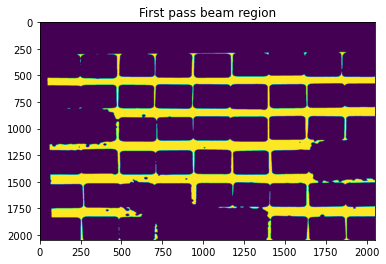

In [36]:
mask = 1.0*(flattened >= 1.3)
Ny,Nx = np.shape(mask)
X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
# manual masking
man_mask = np.ones_like(mask)
man_mask[Y<(290-(X/Nx*25))] = 0
# mask[X>(2048-(Y/Ny*40))] = 0
man_mask[X<(20+(Y/Ny*40))] = 0
# mask[(Y>1840)*(X>1200)*(X<1400)] = 0
# mask[(Y>1600)*(X>1800)*(Y<1770)] = 0
mask= mask*man_mask
beam_mask_approx = 1-(gaussian_filter(mask,7)<0.98)*1.0

imagesc(beam_mask_approx)
plt.title('First pass beam region');


### Fit beam region 

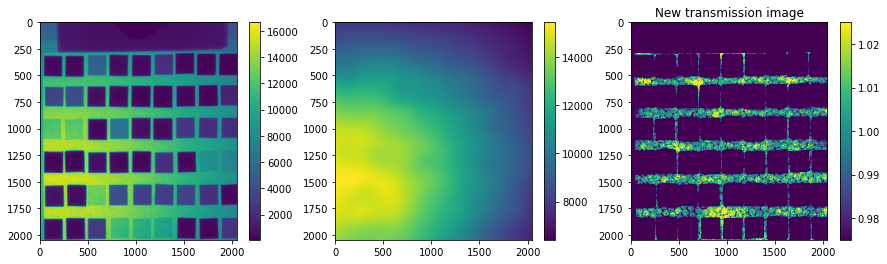

In [37]:
# non-parametric fitting with gaussian process regression
BF = GP_beam_fitter(beam_mask_approx,N_samples = 1000)
beam_estimate,beam_uncertainty = BF.fit_beam(img_sub)

transmission_image_approx = img_sub/beam_estimate

fig,axs=plt.subplots(1,3,figsize=(15,4))

ih = imagesc(img_sub,ax=axs[0])
plt.colorbar(ih,ax=axs[0])
plt.title('Input image')

ih = imagesc(beam_estimate,ax=axs[1])
plt.colorbar(ih,ax=axs[1])
plt.title('Fitted beam')

ih = imagesc(transmission_image_approx,vmin=0.975,vmax=1.025,ax=axs[2])
plt.colorbar(ih,ax=axs[2])
plt.title('New transmission image');


### Second pass

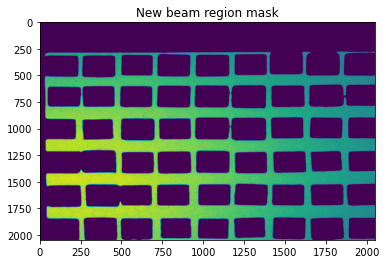

In [38]:
beam_mask_final = (transmission_image_approx >= 0.9)*1.0
beam_mask_final =(gaussian_filter(beam_mask_final,10)>0.5)*1.0
plt.figure()
ax = plt.axes()
imagesc(beam_mask_final*img_sub,ax=ax)
plt.title('New beam region mask');


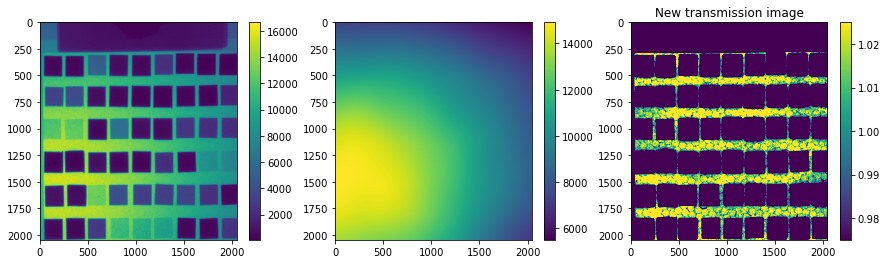

In [39]:
BF = GP_beam_fitter(beam_mask_final,N_samples = 1000,)
beam_estimate,beam_uncertainty = BF.fit_beam(img_sub)

transmission_image = img_sub/beam_estimate

fig,axs=plt.subplots(1,3,figsize=(15,4))

ih = imagesc(img_sub,ax=axs[0])
plt.colorbar(ih,ax=axs[0])
plt.title('Input image')

ih = imagesc(beam_estimate,ax=axs[1])
plt.colorbar(ih,ax=axs[1])
plt.title('Fitted beam')

ih = imagesc(transmission_image,vmin=0.975,vmax=1.025,ax=axs[2])
plt.colorbar(ih,ax=axs[2])
plt.title('New transmission image');


## Define filters regions

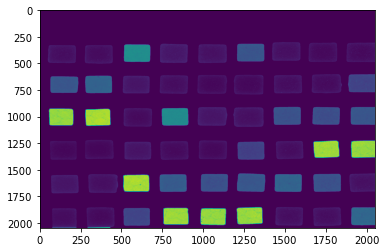

In [117]:

mask = median_filter(transmission_image,5)<0.95
mask = mask*(1-beam_mask_final)*man_mask
mask[1150:1450,240:260] = 0
mask = gaussian_filter(mask,10)>0.95
imagesc(mask*transmission_image)


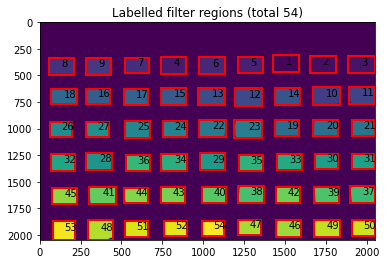

In [118]:

# label discrete regions
labelled = label(mask, background=0,connectivity=2)

# smooth and label again
labelled = labelled*(gaussian_filter(labelled>0,2)>0.5)
labelled = label(labelled, background=0,connectivity=2)

# manually swap some elements to ensure regular pattern
def swap_labels(labelled,lab1,lab2):
    reg1 = labelled==lab1
    reg2 = labelled==lab2
    labelled[reg1] = lab2
    labelled[reg2] = lab1
# swap_labels(labelled,9,8)
# swap_labels(labelled,17,18)
# swap_labels(labelled,19,20)
# swap_labels(labelled,40,41)
# swap_labels(labelled,44,45)
fig,ax=plt.subplots(1,1,figsize=(6,4))

ih = imagesc(labelled,ax=ax)

for region in regionprops(labelled):
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.text(region.centroid[1],region.centroid[0],str(region.label))
        ax.add_patch(rect)
plt.title(f'Labelled filter regions (total {np.max(labelled)})');


In [231]:
from sklearn.cluster import KMeans

def reorder_labels(labelled):
    reg_ps = regionprops(labelled)
    Ny,Nx = np.shape(labelled)
    c_x = np.array([x.centroid[0] for x in reg_ps])
    c_y = np.array([x.centroid[1] for x in reg_ps])
    c_l = np.array([x.label for x in reg_ps])
    reg00_ind = np.argmin(c_x**2+c_y**2)
    reg01_ind = np.argmin((Nx-c_x)**2+c_y**2)
    reg10_ind = np.argmin(c_x**2+(Ny-c_y)**2)
    reg11_ind = np.argmin((Nx-c_x)**2+(Ny-c_y)**2)
    dx = c_x[reg01_ind]-c_x[reg00_ind]
    dy = c_y[reg01_ind]-c_y[reg00_ind]
    dr = np.sqrt(dx**2+dy**2)
    X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
    c_u = c_x*dx/dr + c_y*dy/dr
    c_v = -c_x*dy/dr + c_y*dx/dr
    C_fit = []
    K_list = np.arange(4,20)
    for N_c in K_list:

        KM = KMeans(n_clusters=N_c).fit(c_u.reshape(-1,1))
        C_fit.append(KM.inertia_/np.min(np.diff(np.sort(KM.cluster_centers_.flatten()))))

    N_cu = K_list[np.argmin(C_fit*K_list)]
    KM_u = KMeans(n_clusters=N_cu).fit(c_u.reshape(-1,1))

    C_fit = []
    for N_c in K_list:

        KM = KMeans(n_clusters=N_c).fit(c_v.reshape(-1,1))
        C_fit.append(KM.inertia_/np.min(np.diff(np.sort(KM.cluster_centers_.flatten()))))

    N_cv = K_list[np.argmin(C_fit*K_list)]
    KM_v = KMeans(n_clusters=N_cv).fit(c_v.reshape(-1,1))

    x = np.sort(KM_u.cluster_centers_.flatten())
    y = np.sort(KM_v.cluster_centers_.flatten())
    X,Y = np.meshgrid(x,y)
    X = X.flatten(order='F')
    Y = Y.flatten(order='F')
    # plt.plot(c_u,c_y,'.')
    # plt.plot(KM.cluster_centers_,np.ones(N_c)*1000,'+')

    # plt.plot(KM_u.cluster_centers_.flatten(),KM_v.cluster_centers_.flatten(),'+')
    iOrder = []
    labelled_reordered = labelled*0
    for n,(x,y) in enumerate(zip(X,Y)):
        iSel = np.argmin((c_u-x)**2+(c_v-y)**2)
        iOrder.append(c_l[iSel])
        labelled_reordered[labelled==iOrder[-1]] = n+1
    return labelled_reordered

# iOrder = np.argsort(iOrder)
# labelled2 = labelled*0
# for reg in reg_ps:
#     labbel2[labbelled]

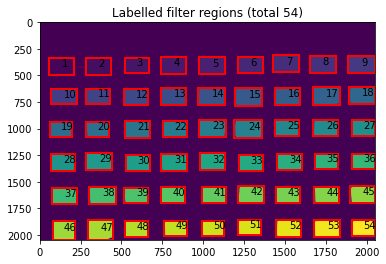

In [256]:
labelled = reorder_labels(labelled)
fig,ax=plt.subplots(1,1,figsize=(6,4))

ih = imagesc(labelled,ax=ax)

for region in regionprops(labelled):
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.text(region.centroid[1],region.centroid[0],str(region.label))
        ax.add_patch(rect)
plt.title(f'Labelled filter regions (total {np.max(labelled)})');


### Load filter pack information and determine orientations

<AxesSubplot:>

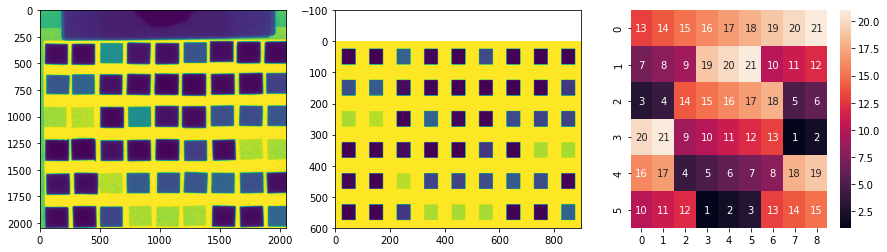

In [253]:
# filter_obj = {
#     'transmission_functions': trans_funcs,
#     'filter_arrangement': filter_arangement,
#     'synthetic_filters': fake_filters,
#     'synthetic_transmission': fake_trans,
#     'filter_fRegions': fList,
#     'null_fRegions': nullList,
# }

run_name_pref = '20200907_run04_shot001'
save_folder = os.path.join(CAL_DATA,'Gematron')
save_file_path = os.path.join(save_folder,
                              'Gematron_filter_pack_'+run_name_pref+'.pkl')
filter_obj = load_object(save_file_path)
synth_trans = filter_obj['synthetic_transmission']
synth_trans = np.flipud((synth_trans))
pack_labels_aligned = np.flipud(filter_obj['filter_arrangement'])[:6,:]
fig,axs=plt.subplots(1,3,figsize=(15,4))
imagesc(transmission_image,ax=axs[0],vmax=1.0)
imagesc(synth_trans,ax=axs[1])
axs[1].set_ylim((600,-100))
sns.heatmap(pack_labels_aligned, annot=True, fmt="d",ax=axs[2])



In [254]:
img_filters = np.zeros_like(transmission_image)
img_filter_labels = np.arange(1,np.max(labelled)+1,1)
img_filter_numbers = pack_labels_aligned.flatten()
for f,l in zip(img_filter_numbers,img_filter_labels):
    img_filters[labelled==l] = f
    

54

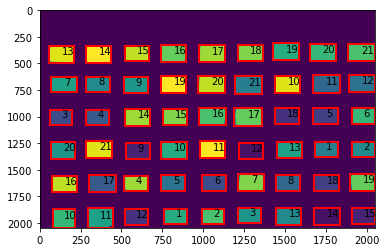

In [257]:
plt.figure()
ax = plt.axes()
imagesc(img_filters,ax=ax)

for n,region in enumerate(regionprops(labelled)):
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.text(region.centroid[1],region.centroid[0],str(img_filter_numbers[n]))
        ax.add_patch(rect)
np.max(labelled)

## Save filter pack beam region and filter region labels

In [258]:
mask_obj = {
    'beam_mask':beam_mask_final,
    'filter_label_regions': labelled,
    'filter_number_regions': img_filters,
    'filter_label': img_filter_labels,
    'filter_number':  img_filter_numbers,    
}

run_name_pref = '20200907_run04_shot001'
save_folder = os.path.join(CAL_DATA,'Gematron')
save_file_path = os.path.join(save_folder,
                              'Gematron_filter_masks_'+run_name_pref+'.pkl')

save_object(mask_obj, save_file_path)


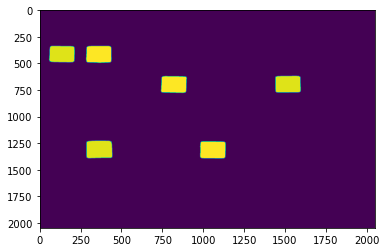

In [259]:
imagesc(img_filters*(img_filters>=20))